# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [50]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
import scipy.misc
import random
import pandas as pd
import tensorflow as tf


%matplotlib inline

#fetching mnist data
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')

# with open('mnist.pickle', 'wb') as f:
#     pickle.dump(mnist, f, pickle.HIGHEST_PROTOCOL)

#loading mnist
file = open("mnist.pickle",'rb')
mnist = pickle.load(file)

mnist_reshape = [mnist.data[i].reshape(28,28) for i in range(len(mnist.data))]

#normalizing data between -0.5 and 0.5
from sklearn.preprocessing import normalize
mnist_reshape = [normalize(mnist_reshape[i]-(256./2.)) for i in range(len(mnist.data))]

mnist_labels = mnist.target

# General exploration of mnist data

- showing that a sample image has not lost integrity

- that the data set has roughly equal numbers

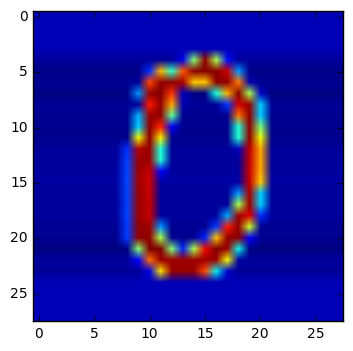

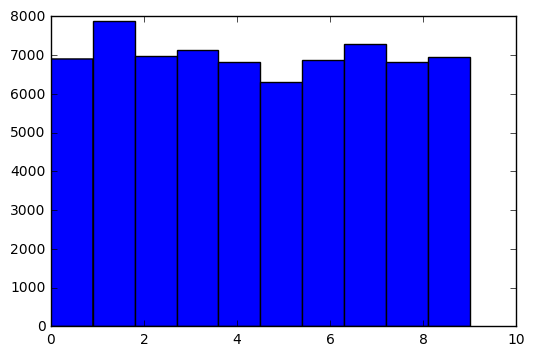

In [52]:
plt.figure(1)
plt.imshow(mnist_reshape[60010])
plt.show()

plt.figure(2)
plt.hist(mnist_labels[0:])
plt.show()

# Randomly Shuffling MNIST Data

- randomizing train and test data with sklearn

- plotting to show that data is randomized properly

In [53]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    mnist_reshape, mnist_labels, test_size=0.1, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

63000 7000 63000 7000


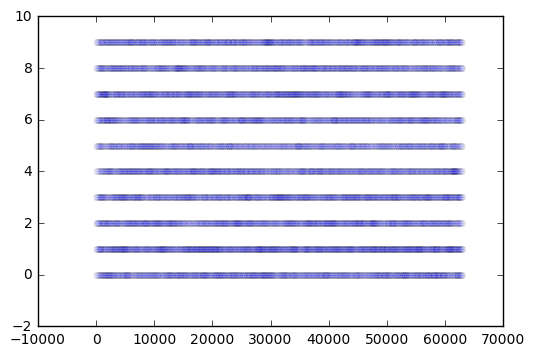

In [54]:
# plt.imshow(X_train[6])
plt.scatter(range(len(y_train[0:70000])), y_train[0:70000], alpha = 0.005)

# Now concatenating numbers

- strategy, since the numbers have been randomized to make sure I use each number I can just take each 1-5mer sequentially from the data lists


In [55]:
#defining a concatenation function for images
def concat_numbers(image_tuple): 
    new_image = np.concatenate(image_tuple, axis = 1)
    return new_image


def make_image(images, labels):
    k = len(images)
    i = 0
    images_new = []
    labels_new = []
    lengths = []
    
    if len(images) != len(labels):
        return ValueError
    
    while i <= k:
        try:
            step = random.randint(1,5)
            images_new = images_new + [concat_numbers(images[i:i+step])]
            labels_new = labels_new + [labels[i:i+step]]
            lengths = lengths + [step]
        except ValueError:
            pass
            
        i = i + step
        if (i % 1000 == 0):
            print(i)
        
        
    return images_new, labels_new, lengths
    
X_train_, y_train_, y_train_lengths = make_image(X_train, y_train)
X_test_, y_test_, y_test_lengths = make_image(X_test, y_test)

3000
5000
6000
10000
14000
17000
20000
21000
24000
28000
32000
37000
40000
42000
45000
46000
47000
48000
53000
7000


21111 2343 21111 2343 21111 2343
47893 5


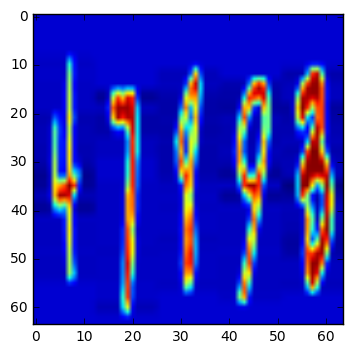

5 5


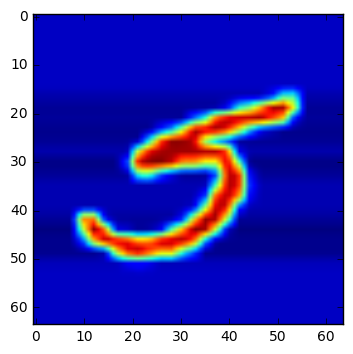

In [56]:
#concatenating labels
y_train_ = [''.join(map(str, i .astype(int))) for i in y_train_]
y_test_ = [''.join(map(str, i .astype(int))) for i in y_test_]

#resizing images to square
X_train_ = [scipy.misc.imresize(i, (64,64)) for i in X_train_]
X_test_ = [scipy.misc.imresize(i, (64,64)) for i in X_test_]



print(len(X_train_), len(X_test_), len(y_train_), len(y_test_), len(y_train_lengths) ,len(y_test_lengths))
print(y_train_[2], y_train_lengths[2])
plt.figure(1)
plt.imshow(X_train_[2]) 
plt.show()

print(y_train_[-10], y_train_lengths[2])
plt.figure(2)
plt.imshow(X_train_[-10])
plt.show()

# Convolutional Neural Network

In [57]:
# #training on mnist first
train_dataset = np.array(X_train_).astype(dtype=np.float32)
train_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in y_train_])

valid_dataset = np.array(X_train_).astype(dtype=np.float32)
valid_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in y_train_])

test_dataset = np.array(X_test_).astype(dtype=np.float32)
test_labels = np.array([[len(i)] + [int(k) for k in i] + [int(10)]*(5-len(i)) for i in y_test_])

In [58]:
image_size = 64
num_labels = 11  #0-9 + blank
num_channels = 1 # grayscale


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (21111, 64, 64, 1) (21111, 6)
Validation set (21111, 64, 64, 1) (21111, 6)
Test set (2343, 64, 64, 1) (2343, 6)


In [48]:
test_labels[0]

array([ 3,  7,  8,  6, 10, 10])

In [13]:
def accuracy(predictions, labels, batch_size):
    pred = [''.join(np.array(i, dtype = int).astype(str)) for i in predictions]
    lab = [''.join(np.array(i, dtype = int).astype(str)) for i in labels]
    correct = sum([np.array(lab[i]==pred[i]).astype(int) for i in range(len(lab))])/float(batch_size)
    return correct*100.

# def accuracy_by_digit(predictions, labels): 
#     predictions = np.array(predictions)[:,:5]
#     lab = np.array(labels)
#     correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
#     percent_correct = [np.mean(i) for i in correct_matrix]
#     return percent_correct

def accuracy_by_digit(predictions, labels): #excludes blanks
    predictions = np.array(predictions)[:,:5]
    lab = np.array(labels)
    
    num_no_10 = [filter(lambda a: a < 10, lab.T[i]) for i in range(5)]
    num_no_10 = [len(i) for i in num_no_10]
    lab[lab > 9] = 11

    correct_matrix = [(np.array(predictions).T[i] == np.array(lab).T[i]).astype(int) for i in range(len(np.array(predictions).T))]
    percent_correct = [float(sum(correct_matrix[i]))/float(num_no_10[i]+0.00001) for i in range(5)]
    return percent_correct

#parameters
batch_size = 16
image_size = 64
num_labels = 11
patch_size = 3
d1 = 16
d2 = 32
d3 = 64
sdev = 0.1 # sdev = math.sqrt(2.0 / (64**2*1))


#tensorflow computational graph
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
    tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
    tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

    # Variables.
    
    conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
    conv1_b = tf.Variable(tf.zeros([d1]))
    
    conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
    conv2_b = tf.Variable(tf.zeros([d2]))
    
    conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
    conv3_b = tf.Variable(tf.zeros([d3]))
    
    fc1_w = tf.Variable(tf.truncated_normal([4096, d3], stddev=0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape=[d3]))
    

    #for final logits
    hidden = 4096
    s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    
    # Model.
    def model(data):
        '''
        Our best architecture consists of eight convolutional hidden layers
        one locally connected hidden layer, and two densely connected hidden layers.
        All connections are feedforward and go from one layer to the next (no skip connections).
        The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
        while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
        The number of units at each spatial location in each layer is [48, 64, 128, 160] 
        for the first four layers and 192 for all other locally connected layers. 
        The fully connected layers contain 3,072 units each. 
        Each convolutional layer includes max pooling and subtractive normalization. 
        The max pooling window size is 2 × 2. 
        The stride alternates between 2 and 1 at each layer, 
        so that half of the layers don’t reduce the spatial size of the representation. 
        All convolutions use zero padding on the input to preserve representation size. 
        The subtractive normalization operates on 3x3 windows and preserves representation size. 
        All convolution kernels were of size 5 × 5. 
        We trained with dropout applied to all hidden layers but not the input.
        '''

        conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding='SAME')
        conv1 = tf.nn.relu(conv1 + conv1_b)
#         print(conv1.get_shape())
        conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding='SAME')
#         print(conv1.get_shape())
        conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding='SAME')
        conv2 = tf.nn.relu(conv2 + conv2_b)
#         print(conv2.get_shape())
        conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding='SAME')
#         print(conv2.get_shape())
        conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding='SAME')
        conv3 = tf.nn.relu(conv3 + conv3_b)
#         print(conv3.get_shape())
        conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding='SAME')
#         print(conv3.get_shape())
        shape = conv3.get_shape().as_list()
        reshape = tf.reshape(conv3, [shape[0], shape[1] * shape[2] * shape[3]])
#         print(reshape.get_shape())
#         fc1 = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
#         
        fc1 = reshape
        fc1 = tf.nn.dropout(fc1, keep_prob = 0.8)

        #five classifiers for each digit
        s1 = tf.matmul(fc1, s1_w) + s1_b
        s2 = tf.matmul(fc1, s2_w) + s2_b
        s3 = tf.matmul(fc1, s3_w) + s3_b
        s4 = tf.matmul(fc1, s4_w) + s4_b
        s5 = tf.matmul(fc1, s5_w) + s5_b

        return [s1, s2, s3, s4, s5]

 
    # Training computation. #no length logit
    [s1, s2, s3, s4, s5] = model(tf_train_dataset)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5]))

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.005).minimize(loss) 
    
    # Predictions for the training and evaluation data
    train_prediction = tf.pack([tf.nn.softmax(s1),
                      tf.nn.softmax(s2),
                      tf.nn.softmax(s3),
                      tf.nn.softmax(s4),
                      tf.nn.softmax(s5)])
    
    eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                             tf.nn.softmax(model(tf_eval)[1]),
                             tf.nn.softmax(model(tf_eval)[2]),
                             tf.nn.softmax(model(tf_eval)[3]),
                             tf.nn.softmax(model(tf_eval)[4])])

    test_prediction = tf.pack([tf.nn.softmax(model(test_dataset)[0]),
                     tf.nn.softmax(model(test_dataset)[1]),
                     tf.nn.softmax(model(test_dataset)[2]),
                     tf.nn.softmax(model(test_dataset)[3]),
                     tf.nn.softmax(model(test_dataset)[4])])
    
    
#     train_prediction = tf.nn.softmax(logits)
#   valid_prediction = tf.nn.softmax(
#     tf.matmul(tf_valid_dataset, weights) + biases)
#   test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    step_t = []
    loss_t = []
    acc_t = []
    
    for step in range(num_steps):
        offset = random.randint(0,len(train_dataset)-batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            labels = batch_labels[:,1:]
            step_t.append(step)
            loss_t.append(l)
            acc_t.append(accuracy_by_digit(pred, labels))
        
        if (step % 1000 == 0):
            
            print(step)
            pred = [list(tf.argmax(predictions[:,i,:],1).eval()) for i in range(batch_size)]
            labels = batch_labels[:,1:]
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy at step %d: %f' % (step, accuracy(pred, labels, batch_size)))
            print('Minibatch accuracy by digit:', accuracy_by_digit(pred, labels))

            print('Minibatch Predictions')
            print(np.array(pred).T)
            print('Minibatch Labels')
            print(np.array(labels).T)
    
    #figures
    #figures
    plt.figure(1)
    plt.plot(step_t[1:], loss_t[1:], label = 'loss')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()

    plt.figure(2)
    acc_T = np.array(acc_t).T
    acc_T = [list(i) for i in acc_T]
    k = 0
    for i in acc_T:
        k = k + 1
        plt.plot(step_t, i, label = 'digit' + str(k))
    plt.xlabel('step')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    save_path = saver.save(session, os.getcwd() + '/STEP1_model.ckpt')
    print("Model saved in file: %s" % save_path)

Initialized
0
Minibatch loss at step 0: 576.137207
Minibatch accuracy at step 0: 0.000000
Minibatch accuracy by digit: [0.125, 0.125, 0.0625, 0.0625, 0.0]
Minibatch Predictions
[[ 0  3  4  4  4  4  3  4  4  3  4  3 10  6  4 10]
 [ 2  2  2  1 10  7  1  1  1  2  1 10  1  1 10  2]
 [ 5  1  1  9  0  1  0  8  0 10  8  1  1  5  7  1]
 [ 2  4  4  4  4  4  4  9  4  4  4  4  1  4  4  4]
 [ 3  0  1  6  1  6  1  6  6  3  6  6  6  6  1  6]]
Minibatch Labels
[[ 1  2  8  3  3  2  4  8  9  1  4  3  2  1  0  9]
 [ 4  1  2  4  8  5 10  5  9 10  0  7  8  7 10  0]
 [10 10  8  6 10  0 10  3  7 10  1  9 10  1 10  0]
 [10 10  5 10 10 10 10 10 10 10 10  2 10 10 10  4]
 [10 10  3 10 10 10 10 10 10 10 10  5 10 10 10  8]]
1000
Minibatch loss at step 1000: 2.181821
Minibatch accuracy at step 1000: 50.000000
Minibatch accuracy by digit: [0.8125, 0.6875, 0.75, 0.875, 1.0]
Minibatch Predictions
[[ 2  9  7  9  0  1  2  2  7  9  1  9  9  5  4  2]
 [10  7  3 10  4  1  9  3  3  7  0  2  0 10  3  3]
 [10  3  7 10 10 10 

In [126]:
def predict_with_model(y, model_name, test_size):

    batch_size = 16
    image_size = 64
    num_labels = 11
    patch_size = 3
    d1 = 16
    d2 = 32
    d3 = 64
    sdev = 0.1 # sdev = math.sqrt(2.0 / (64**2*1))
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))
        tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size,6))
        tf_eval = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, 1))

        # Variables.

        conv1_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, 1, d1], stddev=sdev))
        conv1_b = tf.Variable(tf.zeros([d1]))

        conv2_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d1, d2], stddev=sdev))
        conv2_b = tf.Variable(tf.zeros([d2]))

        conv3_w = tf.Variable(tf.truncated_normal([patch_size, patch_size, d2, d3], stddev=sdev))
        conv3_b = tf.Variable(tf.zeros([d3]))

        fc1_w = tf.Variable(tf.truncated_normal([4096, d3], stddev=0.1))
        fc1_b = tf.Variable(tf.constant(1.0, shape=[d3]))


        #for final logits
        hidden = 4096
        s1_w = tf.get_variable('s1_w', shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s2_w = tf.get_variable('s2_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s3_w = tf.get_variable('s3_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s4_w = tf.get_variable('s4_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        s5_w = tf.get_variable('s5_w',shape=[hidden, num_labels],initializer=tf.contrib.layers.xavier_initializer())
        s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))


        # Model.
        def model(data):
            '''
            Our best architecture consists of eight convolutional hidden layers
            one locally connected hidden layer, and two densely connected hidden layers.
            All connections are feedforward and go from one layer to the next (no skip connections).
            The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit)
            while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). 
            The number of units at each spatial location in each layer is [48, 64, 128, 160] 
            for the first four layers and 192 for all other locally connected layers. 
            The fully connected layers contain 3,072 units each. 
            Each convolutional layer includes max pooling and subtractive normalization. 
            The max pooling window size is 2 × 2. 
            The stride alternates between 2 and 1 at each layer, 
            so that half of the layers don’t reduce the spatial size of the representation. 
            All convolutions use zero padding on the input to preserve representation size. 
            The subtractive normalization operates on 3x3 windows and preserves representation size. 
            All convolution kernels were of size 5 × 5. 
            We trained with dropout applied to all hidden layers but not the input.
            '''

            conv1 = tf.nn.conv2d(data, conv1_w, [1, 1, 1, 1], padding='SAME')
            conv1 = tf.nn.relu(conv1 + conv1_b)
    #         print(conv1.get_shape())
            conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], padding='SAME')
    #         print(conv1.get_shape())
            conv2 = tf.nn.conv2d(conv1, conv2_w, [1, 1, 1, 1], padding='SAME')
            conv2 = tf.nn.relu(conv2 + conv2_b)
    #         print(conv2.get_shape())
            conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], padding='SAME')
    #         print(conv2.get_shape())
            conv3 = tf.nn.conv2d(conv2, conv3_w, [1, 1, 1, 1], padding='SAME')
            conv3 = tf.nn.relu(conv3 + conv3_b)
    #         print(conv3.get_shape())
            conv3 = tf.nn.max_pool(conv3, [1,2,2,1], [1,2,2,1], padding='SAME')
    #         print(conv3.get_shape())
            shape = conv3.get_shape().as_list()
            reshape = tf.reshape(conv3, [shape[0], shape[1] * shape[2] * shape[3]])
    #         print(reshape.get_shape())
    #         fc1 = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
    #         
            fc1 = reshape
            fc1 = tf.nn.dropout(fc1, keep_prob = 0.8)

            #five classifiers for each digit
            s1 = tf.matmul(fc1, s1_w) + s1_b
            s2 = tf.matmul(fc1, s2_w) + s2_b
            s3 = tf.matmul(fc1, s3_w) + s3_b
            s4 = tf.matmul(fc1, s4_w) + s4_b
            s5 = tf.matmul(fc1, s5_w) + s5_b

            return [s1, s2, s3, s4, s5]


        # Training computation. #no length logit
        [s1, s2, s3, s4, s5] = model(tf_train_dataset)

        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(s5, tf_train_labels[:,5]))

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.005).minimize(loss) 

        # Predictions for the training and evaluation data
        train_prediction = tf.pack([tf.nn.softmax(s1),
                          tf.nn.softmax(s2),
                          tf.nn.softmax(s3),
                          tf.nn.softmax(s4),
                          tf.nn.softmax(s5)])

        eval_prediction = tf.pack([tf.nn.softmax(model(tf_eval)[0]),
                                 tf.nn.softmax(model(tf_eval)[1]),
                                 tf.nn.softmax(model(tf_eval)[2]),
                                 tf.nn.softmax(model(tf_eval)[3]),
                                 tf.nn.softmax(model(tf_eval)[4])])

        test_prediction = tf.pack([tf.nn.softmax(model(test_dataset)[0]),
                         tf.nn.softmax(model(test_dataset)[1]),
                         tf.nn.softmax(model(test_dataset)[2]),
                         tf.nn.softmax(model(test_dataset)[3]),
                         tf.nn.softmax(model(test_dataset)[4])])
        
        with tf.Session(graph=graph) as sess:

            sess.run(tf.initialize_all_variables())
            saver.restore(sess, os.getcwd() + model_name)
            
            pred = [(tf.argmax(test_prediction[:,i,:],1).eval()) for i in range(test_size)]
            
            return pred

test_size = 500
y = test_dataset[0:test_size]
predictions = predict_with_model(y, '/STEP1_model.ckpt', test_size)
d_accur = accuracy_by_digit(predictions, test_labels[:test_size,1:])
k = 1
for i in d_accur:
    print('digit ', k, ': ', i)
    k = k + 1
    
plt.show()

digit  1 :  0.9
digit  2 :  0.777777777778
digit  3 :  0.8
digit  4 :  0.731707317073
digit  5 :  0.826086956522


#### WIth this model with 3 Convlutional layers and 1 fully connected layer.  I am getting reasonable accuracy at each digit.  For the most part it does pretty well.  this is definitely a much harder problem than with MNIST single digits.